# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import missingno as msno
from googletrans import Translator

# import sys
# from IPython.display import display
# import pprint
# import itertools
# import math
# import nltk
# from nltk.corpus import wordnet

'''
custom modules
'''
# function similar to Excel's vlookup
from vlookup import vlookup
from vlookuporg import vlookup_org
# function to view all contents of a dataframe
from view_all import view_all

In [2]:
# pip install googletrans==4.0.0-rc1
# pip install missingno
# custom modules for convenience are in root folder

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Load and overview

**[function]**

In [4]:
def msno_overview (data, chunk_size = 100):
    '''
    function to display missing value using missingno library
    data: dataframe
    chunk_size: int, size of column chunk, 100 as default  
    '''
    # split data columns into chunks
    chunk_size = chunk_size
    column_chunks = [data.iloc[:, i : i + chunk_size] for i in range(0, data.shape[1], chunk_size)]

    # generate and display missingno plots for each chunk
    for i, j in enumerate(column_chunks):
        msno.matrix(j, figsize = (10, 3), fontsize = 8, labels = False, sparkline = False)
        plt.title(
            f'{data.name}: missing value overview - column {i * 100} to {min (i * chunk_size + chunk_size - 1, data.shape[1] - 1)}',
            fontsize = 10);

#### 1.1 azdias

In [5]:
# 제출전 주석 해제
# '''
# load and file overview
# '''

# azdias = pd.read_csv('../csv_pickle/Udacity_AZDIAS_052018.csv', sep=';')
# azdias.name = 'azdias'
#
# print (azdias.info())
# azdias.head()

In [6]:
azdias = pd.read_pickle('../csv_pickle/azdias.pickle')

print (azdias.info())
azdias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
# '''
# missing value overview
# '''

# azdias.name = 'azdias'
# msno_overview(azdias)

#### 1.2 customers

In [8]:
# 제출전 주석 해제
# '''
# load and file overview
# '''

# customers = pd.read_csv('../csv_pickle/Udacity_CUSTOMERS_052018.csv', sep=';')
# print (customers.info())
# customers.head()

In [9]:
customers = pd.read_pickle('../csv_pickle/customers.pickle')

print (customers.info())
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
# '''
# missing value overview
# '''

# customers.name = 'customers'
# msno_overview(customers)

#### 1.3 info

In [11]:
'''
load and overview
'''

info = pd.read_excel(
    'DIAS Information Levels - Attributes 2017.xlsx', header=1).iloc[:, 1:]

print (info.info())
info.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  10 non-null     object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB
None


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN


#### 1.4 attr

In [53]:
'''
load and overview
'''

attr = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', header=1).iloc[:, 1:]
# rename column Value to Score for easier documentation
attr = attr.rename(columns = {'Value' : 'Score'})

print (attr.info())
attr[103:108]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Score        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None


,Attribute,Description,Score,Meaning
103,NaN,NaN,9D,Mini-Jobber
104,NaN,NaN,9E,Socking Away
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,NaN,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,NaN,NaN,12,Wealthy Households-Young Couples With Children


### 2. Baseline understanding

**2자리 넘버링으로 정리 되도록 함**

There are 4 files given:
* 2 dataset files - azdias & customers
* 2 reference files - info & attr:  
  - info is for information on dataset features which are in unreadable German acronyms  
  - attr is for information on dataset values which are in numbers and acronyms,  
  and has corresponding meanings  

To establish a baseline, this section aims to identify key factors in the reference files   
that can help in understanding the contents of the dataset.

**[function]**

In [13]:
def str_to_num (number):
    '''
    function to change dtype of numbers in string form
    '''
    if isinstance(number, str) and (
        number.isdigit() or (number.startswith('-') and number[1:].isdigit())):
        return int(number)
    else:
        return number

In [14]:
def ger_to_eng (ger_text):
    '''
    function to translate German text
    '''
    translator = Translator(service_urls=['translate.google.com'])    
    try:
        translation = translator.translate(ger_text, src='de', dest='en')
        return translation.text        
    except:
        return np.nan

In [15]:
def pv_min_max(data, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes'], display = True):
    '''
    function to display min/max values of Score after adding information from feature_desc
    
    data : dataframe to examine
    pv_idx: list of pivot_table index
    display: boolean, selection of result display
    '''
    data = vlookup(data, feature_desc, 'Attribute', ['Desc', 'Additional notes'], fill_na = 'no_info')
    pv = pd.pivot_table(
        data,
        index = pv_idx,
        values = 'Score',
        aggfunc = [min, max]
        )
        
    pv['min_max_cat'] = pv['min'].astype(int).astype(str) + ' to ' + pv['max'].astype(int).astype(str)
    pv = pv.sort_values(by = 'min_max_cat')
    
    pv = pd.DataFrame(pv.to_records())
    pv.columns = list(pv.columns[:-3]) + list(eval(i)[0] for i in pv.columns[-3:])
    print (f'number of Attribute(s): {data.Attribute.nunique()}')

    if display:
        print (pv.min_max_cat.unique())
    
    return pv

In [16]:
def pv_meaning_score(
    data, 
    pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes'],
    pv_val = ['Meaning', 'Score'],
    display = True
    ):
    '''
    function to display the summary of Meaning and Score values
    after adding information from feature_desc
    
    data : dataframe to examine
    pv_idx: list of pivot_table index
    pv_val: list of pivot_table value
    display: boolean, selection of result display
    '''
    data = vlookup(data, feature_desc, 'Attribute', ['Desc', 'Additional notes'], fill_na = 'no_info')
    pv = pd.pivot_table(
        data,
        index = pv_idx,
        values = pv_val,
        aggfunc = lambda x: list(x))
    
    pv = pd.DataFrame(pv.to_records())
    print (f'number of Attribute(s): {data.Attribute.nunique()}')
    
    if display:
        view_all(pv.iloc[:5])
    
    return pv

In [17]:
def pv_verify_null(
    data,
    null_list,
    pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes'], 
    pv_val = ['Meaning', 'Score'],    
    display = True
    ):
    '''
    function to display the summary of Meaning and Score values
    when Meaning values are in the list containing possibly null values 
    
    data: dataframe to examine
    null_list: list of possibly null values
    pv_idx: pivot_table index
    pv_val: list of pivot_table value
    display: boolean, selection of result display
    '''
    null_check_Attribute = data.query('Meaning in @null_list').Attribute.to_list()
    null_check = data.query('Attribute in @null_check_Attribute')
    
    pv = pv_meaning_score(null_check, pv_idx, pv_val, display)
    
    return pv

#### 2.1 reference features from info

As datasets do not have information on what each column feature exactly means,  
values of reference files have to be mapped to the features.
  
feature_desc below is for this needs, and formed with 369 column features from customers. 

After merging information columns, there are 264 features from both customers and info,  
along with 105 exclusive features of customers lacking Description values.

In [18]:
'''
feature_desc with column features of customers and added information from info 
'''

feature_desc = pd.DataFrame(customers.columns, columns=['Attribute'])
feature_desc = vlookup(feature_desc, info, 'Attribute')

'''
To fill missing Descriptions, add some values from attr and create translation using googletrans.
The result is saved in the root folder due to the time-consuming code execution.
'''
# # for Attribute without Description, add 12 Description values from attr
# feature_desc = vlookup(feature_desc, attr, 'Attribute', 'Description', intsec = 'update')

# # add Desc (colum of translation) using ger_to_eng
# feature_desc['ger_to_eng'] = np.where(
#     feature_desc.Description.isnull(),
#     feature_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# feature_desc['Desc'] = feature_desc.Description.fillna('') + feature_desc.ger_to_eng.fillna('')

feature_desc = pd.read_excel('feature_desc.xlsx', index_col = [0])
feature_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Attribute          369 non-null    object
 1   Information level  9 non-null      object
 2   Additional notes   17 non-null     object
 3   Description        276 non-null    object
 4   ger_to_eng         93 non-null     object
 5   Desc               369 non-null    object
dtypes: object(6)
memory usage: 20.2+ KB


#### 2.2 feature alignment

The improved readability of feature_desc has enhanced the understanding  
of the overall structure of the datasets and the meanings of the features,  
although some translations still remain unclear.  

Since there are a few features that have similar contents, it is necessary  
to perform imputation steps to resolve collinearity and reduce dimensionality  
before proceeding with the modeling process.

The following cells provide an overview of the number of features in each file  
and illustrates the feature intersection and difference between the files.

In [19]:
feature_dict = {
    'azdias' : set(azdias.columns.unique()),
    'customers' : set(customers.columns.unique()),
    'info' : set(info.Attribute.dropna().unique()),
    'attr' : set(attr.Attribute.dropna().unique()),
    'feature_desc' : set(feature_desc.Attribute.dropna().unique())
    }

print ('Number of features by file')
for k, v in feature_dict.items():
    print (k, ':', len(v))

Number of features by file
azdias : 366
customers : 369
info : 313
attr : 314
feature_desc : 369


In [20]:
print ('Feature intersection & difference between files')
for i in range(0, 5):
    for j in range (0, 5):
        if i == j:
            continue
        
        key_1 = list(feature_dict.keys())[i]
        key_2 = list(feature_dict.keys())[j]
        set_1 = list(feature_dict.values())[i]
        set_2 = list(feature_dict.values())[j]
        
        intsec = set_1.intersection(set_2)
        ft_diff = set_1 - set_2
        feature_dict[f'{key_1}_intsec_{key_2}'] = intsec
        feature_dict[f'in_{key_1}_notin_{key_2}'] = ft_diff
        
        intsec_print = f'{key_1} & {key_2} intersection:'
        ft_diff_print = f' /  in {key_1} & not-in {key_2}:'        
        print (intsec_print, str(len(intsec)).rjust(41 - len(intsec_print)),
               ft_diff_print, str(len(ft_diff)).rjust(40 - len(ft_diff_print)))

Feature intersection & difference between files
azdias & customers intersection:       366  /  in azdias & not-in customers:       0
azdias & info intersection:            264  /  in azdias & not-in info:          102
azdias & attr intersection:            272  /  in azdias & not-in attr:           94
azdias & feature_desc intersection:    366  /  in azdias & not-in feature_desc:    0
customers & azdias intersection:       366  /  in customers & not-in azdias:       3
customers & info intersection:         264  /  in customers & not-in info:       105
customers & attr intersection:         272  /  in customers & not-in attr:        97
customers & feature_desc intersection: 369  /  in customers & not-in feature_desc: 0
info & azdias intersection:            264  /  in info & not-in azdias:           49
info & customers intersection:         264  /  in info & not-in customers:        49
info & attr intersection:              300  /  in info & not-in attr:             13
info & feature_de

#### 2.3 reference values from attr

After identifying the dataset structure in parts 2.1 and 2.2 above,  
part 2.3 focuses on examining the dataset contents.  
In this part, various aspects such as the ranges of feature values,  
values actually meaning null, data types, and more are to be verified,  
and preliminary notes will be recorded on pre-processing requirements.

<!-- ##### 2.3.0 attr modification -->

Considering that info contains information about dataset features, attr contains  
information about dataset values and the values within the datasets can be understood  
by mapping them to the corresponding Meaning values in attr.

However, it is necessary to initially modify attr since it is not in a neat form:
* 2 numbers in 1 str value like '-1, 0' or number(s) in str like '-1'
* add-on information cell below Description value cell
* only 1st rows of Attribute & Description with values, etc.

* clean attr

In [54]:
# keep attr original
attr_org = attr.copy()

'''
change numbers in str form
'''
# 2 numbers in 1 str value
attr.Score = attr.Score.apply(
    lambda x: [int(i) for i in x.split(',')] if isinstance(x, str) and ',' in x else x)
attr = attr.explode('Score')
# '-1' to -1
attr.Score = attr.Score.apply(str_to_num)

'''
merge add-on information in some cells below Description
'''
# create attribute and description_shift with shift(-1)
attr['attribute_shift'] = attr.Attribute.shift(-1).fillna('')
attr['description_shift'] = attr.Description.shift(-1).fillna('')
# merge Description and add-on
attr.Description = attr.Description.mask(
    (~(attr['Attribute'].isna()) & (attr['attribute_shift'].isna())),
    attr.Description + ' ' + attr.description_shift)
# replace add-on with np.nan
attr.Description = attr.Description.mask(
    (attr['Attribute'].isna()) & ~(attr['Description'].isna()),
    np.nan)
# drop description shift
attr = attr.drop(['attribute_shift', 'description_shift'], axis = 1)

'''
fill blank cells with corresponding values as only 1st lines
of Attribute & Description have values
'''

attr[['Attribute', 'Description']] = attr[
    ['Attribute', 'Description']].fillna(method = 'ffill')

'''
keep 272 intersection features between attr and datasets,
and drop exclusive features of datasets that are not useful at this step
'''

attr = attr[attr.Attribute.isin(feature_dict['attr_intsec_customers'])] # simple query not working

print (f'number of Attribute: {attr.Attribute.nunique()}')
attr.info()

number of Attribute: 272
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2004 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    2004 non-null   object
 1   Description  2004 non-null   object
 2   Score        2004 non-null   object
 3   Meaning      1993 non-null   object
dtypes: object(4)
memory usage: 78.3+ KB


In [55]:
'''
A small issue detected here is that there are 11 lines without value of Meaning.  
From the examination below, 2 features involved with these lines can be dropped,  
as they have other features with similar but more detailed Meaning values.

2 features are without Meaning values
'''

print (attr.query('Meaning.isnull()').Attribute.value_counts())

'''
these features can be dropped, as they have similar features
with more detailed Meaning values
'''

attribute_without_meaning = attr.query('Attribute.str.contains("LP_FAMILIE|LP_STATUS")')
print (attribute_without_meaning.query('Score > 8'))

LP_FAMILIE_GROB    6
LP_STATUS_GROB     5
Name: Attribute, dtype: int64
            Attribute          Description Score                       Meaning
1900  LP_FAMILIE_FEIN       familytyp fine     9                   shared flat
1901  LP_FAMILIE_FEIN       familytyp fine    10    two-generational household
1902  LP_FAMILIE_FEIN       familytyp fine    11  multi-generational household
1911  LP_FAMILIE_GROB      familytyp rough     9         multiperson household
1912  LP_FAMILIE_GROB      familytyp rough    10                           NaN
1913  LP_FAMILIE_GROB      familytyp rough    11                           NaN
1974   LP_STATUS_FEIN   social status fine     9                   houseowners
1975   LP_STATUS_FEIN   social status fine    10                  top earners 
1984   LP_STATUS_GROB  social status rough     9                           NaN
1985   LP_STATUS_GROB  social status rough    10                  top earners 


In [32]:
'''
NOTE dict p_process to note points to be pre-processed
'''

p_process = {'2.3' : 'drop features LP_FAMILIE_GROB / LP_STATUS_GROB'}

# remove 2 features from attr
attr = attr.query('Attribute not in ["LP_FAMILIE_GROB", "LP_STATUS_GROB"]')

* create pre-study dataframes by value form of Score

In [33]:
'''
add delimiter column Score_form
'''

attr = attr.copy() # to avoid SettingWithCopyWarning
attr['Score_form'] = attr.Score.map(type)
attr.Score_form.value_counts()

<class 'int'>    1930
<class 'str'>      53
Name: Score_form, dtype: int64

In [34]:
'''
attr_num containing Scores denoted in number
'''

attr_num = attr[attr.Score_form == int].copy()
print (f'number of Attribute(s): {attr_num.Attribute.nunique()}')

number of Attribute(s): 262


In [35]:
'''
attr_str containing Scores denoted in string
'''

attr_str = attr[attr.Score_form == str].copy()
print (f'number of Attribute(s): {attr_str.Attribute.nunique()}')

number of Attribute(s): 9


In [36]:
'''
there is 1 feature that Scores are in both numeric and string forms
'''

set(attr_num.Attribute.unique()).intersection(set(attr_str.Attribute.unique()))

{'OST_WEST_KZ'}

##### 2.3.1 attr Scores denoted in number

From min/max categories 를 만들었으며, to be further checked are:   
* If Score -1 and 0 contain data equal to null or -inf  
* If max Score values contain data equal to null or inf
* If features with wider min/max gap are discrete or continuous

In [37]:
'''
summary of attr_num with min/max value observed
'''

attr_num_score = pv_min_max(attr_num)

number of Attribute(s): 262
['-1 to -1' '-1 to 15' '-1 to 2' '-1 to 3' '-1 to 4' '-1 to 5' '-1 to 6'
 '-1 to 7' '-1 to 8' '-1 to 9' '0 to 1' '0 to 10' '0 to 21' '0 to 5'
 '0 to 6' '1 to 10' '1 to 11' '1 to 12' '1 to 40' '1 to 5' '1 to 6'
 '1 to 7' '1 to 9']


* **cases of Score -1 and 0**
     
  i) All Score value -1s in datasets should be replaced to null,  
    as the reference of attr shows that it always means unknown.

  ii) Few Score value 0s can be replaced to null if the corresponding  
    value of Meaning is in list to_null.

  iii) All other Score value 0s should be remained, as the reference  
    of attr shows value 0 is not meaning null in nearly all cases.  

  Analyses for this conclusion are in the following cells.

In [38]:
'''
when Score value is -1, the meaning is 100% unknown in reference file
'''

attr_num.query('Score < 0').Meaning.value_counts()

unknown    222
Name: Meaning, dtype: int64

In [39]:
'''
when Score value is 0, it means none in most cases,
and there are also some corresponding Meaning values
that seem to be definitely equal to null
'''

attr_num.query('Score == 0').Meaning.value_counts()

none                                                136
unknown                                              15
no transactions known                                10
no Online-transactions within the last 12 months      3
no classification possible                            1
unknown / no main age detectable                      1
doesn't belong to the green avantgarde                1
classification not possible                           1
no 1-2 family homes                                   1
no 3-5 family homes                                   1
no 6-10 family homes                                  1
no >10 family homes                                   1
external supplied hedonists                           1
no score calculated                                   1
Name: Meaning, dtype: int64

In [42]:
'''
select Meaning values which seems to be definitely null,
and verify them
'''
to_null = ['unknown', 'no transactions known', 'no classification possible',
           'unknown / no main age detectable', 'classification not possible',
           'no score calculated'
            ]

verify_to_null = pv_verify_null(attr_num, to_null)

number of Attribute(s): 247


,Attribute,Description,Desc,Additional notes,Meaning,Score
0,AGER_TYP,best-ager typology,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,"[unknown, no classification possible, passive elderly, cultural elderly, experience-driven elderly]","[-1, 0, 1, 2, 3]"
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,age classification through prename analysis,modelled on millions of first name-age-reference data,"[unknown, unknown, < 30 years, 30 - 45 years, 46 - 60 years, > 60 years, uniformly distributed]","[-1, 0, 1, 2, 3, 4, 9]"
2,ALTER_HH,main age within the household,main age within the household,no_info,"[unknown / no main age detectable, 01.01.1895 bis 31.12.1899, 01.01.1900 bis 31.12.1904, 01.01.1905 bis 31.12.1909, 01.01.1910 bis 31.12.1914, 01.01.1915 bis 31.12.1919, 01.01.1920 bis 31.12.1924, 01.01.1925 bis 31.12.1929, 01.01.1930 bis 31.12.1934, 01.01.1935 bis 31.12.1939, 01.01.1940 bis 31.12.1944, 01.01.1945 bis 31.12.1949, 01.01.1950 bis 31.12.1954, 01.01.1955 bis 31.12.1959, 01.01.1960 bis 31.12.1964, 01.01.1965 bis 31.12.1969, 01.01.1970 bis 31.12.1974, 01.01.1975 bis 31.12.1979, 01.01.1980 bis 31.12.1984, 01.01.1985 bis 31.12.1989, 01.01.1990 bis 31.12.1994, 01.01.1995 bis 31.12.1999]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
3,ANREDE_KZ,gender,gender,no_info,"[unknown, unknown, male, female]","[-1, 0, 1, 2]"
4,BALLRAUM,distance to next urban centre,distance to next urban centre,no_info,"[unknown, till 10 km, 10 - 20 km, 20 - 30 km, 30 - 40 km, 40 - 50 km, 50-100 km, more than 100 km ]","[-1, 1, 2, 3, 4, 5, 6, 7]"


In [43]:
maybe_null = ['none']

'''
check if none is also equal to null and should be added to to_nul:
none does not mean null in any case (see examples below).
'''

verify_maybe_null = pv_verify_null(attr_num, maybe_null)

number of Attribute(s): 137


,Attribute,Description,Desc,Additional notes,Meaning,Score
0,KBA05_ALTER1,share of car owners less than 31 years old,share of car owners less than 31 years old,no_info,"[unknown, unknown, none, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4]"
1,KBA05_ALTER4,share of cars owners elder than 61 years,share of cars owners elder than 61 years,no_info,"[unknown, unknown, none, very low, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4, 5]"
2,KBA05_ANHANG,share of trailers in the microcell,share of trailers in the microcell,no_info,"[unknown, unknown, none, some, some more, very many]","[-1, 9, 0, 1, 2, 3]"
3,KBA05_CCM4,share of cars with more than 2499ccm,share of cars with more than 2499ccm,no_info,"[unknown, unknown, none, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4]"
4,KBA05_DIESEL,share of cars with Diesel-engine in the microcell,share of cars with Diesel-engine in the microcell,no_info,"[unknown, unknown, none, very low, low, average, high]","[-1, 9, 0, 1, 2, 3, 4]"


In [44]:
'''
NOTE pre-processing items
'''

p_process['2.3.1-value_-1'] = 'replace all -1 Score to null'
p_process['2.3.1-to_null'] = 'replace Scores, of which corresponding Meanings are in to_null, to null'

* **max Score values**  
  
  some Meaning values linked to max Scores seem to possibly be null.  
  However most of them are not verified as null or already in list to_null. 

In [45]:
'''
Meaning values corresponding to max Scores
'''
# row indexes corresponding to max Scores of Attributes  
attr_num['Score'] = attr_num.Score.astype(float)
max_idx = attr_num.groupby('Attribute')['Score'].idxmax()

attr_num.loc[max_idx].Meaning.unique()

array(['experience-driven elderly', 'uniformly distributed',
       '01.01.1995 bis 31.12.1999', 'female', 'more than 100 km ',
       'urban working class',
       'Advertising-Enthusiast with restricted Cross-Channel-Behaviour ',
       'very high activity', 'no transactions known',
       '100% Online-transactions within the last 12 months', 'Inactive',
       'more than 999 HH/²', 'unremarkable', 'very low',
       'mixed building without actually known company ',
       'residential cell', 'without vacation',
       'belongs to the green avantgarde', 'jaunty hedonists ',
       'very low income', 'distance to the city centre > 40 km',
       'unknown', 'very high share of 1-2 family homes',
       'very high share of 3-5 family homes',
       'high share of 6-10 family homes',
       'high share of >10 family homes',
       'mainly business buildings in the microcell', '>=23 buildings',
       'very high', 'high', 'mainly very big engines', 'low',
       'building is not located i

In [46]:
'''
select Meaning values to be checked
'''
maybe_null = ['uniformly distributed', 'no transactions known', 'Inactive', 'unremarkable',
              'unknown', 'other', 'indifferent']

# filter values already in to_null
maybe_null = [i for i in maybe_null if i not in to_null]
maybe_null

['uniformly distributed', 'Inactive', 'unremarkable', 'other', 'indifferent']

In [47]:
'''
check if Meaning values of maybe_null should be added to to_nul
'''

verify_maybe_null = pv_verify_null(attr_num, maybe_null)

number of Attribute(s): 5


,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ALTERSKATEGORIE_GROB,age classification through prename analysis,age classification through prename analysis,modelled on millions of first name-age-reference data,"[unknown, unknown, < 30 years, 30 - 45 years, 46 - 60 years, > 60 years, uniformly distributed]","[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 9.0]"
1,D19_KONSUMTYP,consumption type,consumption type,no_info,"[Universal, Versatile, Gourmet, Family, Informed , Modern, Inactive]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0]"
2,FINANZTYP,best descirbing financial type for the person,best descirbing financial type for the person,no_info,"[unknown, low finacial interest, money saver, main focus is the own house, be prepared, Investor, unremarkable]","[-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]"
3,TITEL_KZ,flag whether this person holds an academic title,flag whether this person holds an academic title,no_info,"[unknown, unknown, Dr., Dr. Dr., Prof., Prof. Dr., other]","[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]"
4,ZABEOTYP,typification of energy consumers,typification of energy consumers,modelled on different AZ DIAS data,"[unknown, unknown, green, smart, fair supplied, price driven, seeking orientation, indifferent]","[-1.0, 9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]"


In [48]:
'''
form list maybe_null add only 'inactive' to to_null,
as other values seems to have their own meanings
'''

to_null.append('Inactive')

* **data type of features with wider min/max Score gap**
  
  All features that have min/max Score gap over 10 are found to be discrete

In [49]:
'''
check features that have min/max Score gap over 10
'''
# from attr_num_score above, extract Attribute values having min/max Score gap over 10
gap_over10_attribute = attr_num_score[
    (attr_num_score['max'] - attr_num_score['min']) > 10].Attribute.unique()

gap_over10 = pv_meaning_score(
    attr_num.query('Attribute in @gap_over10_attribute'))

number of Attribute(s): 5


,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ALTER_HH,main age within the household,main age within the household,no_info,"[unknown / no main age detectable, 01.01.1895 bis 31.12.1899, 01.01.1900 bis 31.12.1904, 01.01.1905 bis 31.12.1909, 01.01.1910 bis 31.12.1914, 01.01.1915 bis 31.12.1919, 01.01.1920 bis 31.12.1924, 01.01.1925 bis 31.12.1929, 01.01.1930 bis 31.12.1934, 01.01.1935 bis 31.12.1939, 01.01.1940 bis 31.12.1944, 01.01.1945 bis 31.12.1949, 01.01.1950 bis 31.12.1954, 01.01.1955 bis 31.12.1959, 01.01.1960 bis 31.12.1964, 01.01.1965 bis 31.12.1969, 01.01.1970 bis 31.12.1974, 01.01.1975 bis 31.12.1979, 01.01.1980 bis 31.12.1984, 01.01.1985 bis 31.12.1989, 01.01.1990 bis 31.12.1994, 01.01.1995 bis 31.12.1999]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0]"
1,GFK_URLAUBERTYP,vacation habits,vacation habits,no_info,"[Event travelers, Family-oriented vacationists, Winter sportspeople, Culture lovers, Nature fans, Hiker, Golden ager, Homeland-connected vacationists , Package tour travelers, Connoisseurs, Active families, without vacation]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]"
2,LP_LEBENSPHASE_FEIN,lifestage fine,lifestage fine,modelled on different AZ DIAS data,"[single low-income earners of younger age, single low-income earners of middle age, single average earners of younger age , single average earners of middle age, single low-income earners of advanced age, single low-income earners at retirement age , single average earners of advanced age, single average earners at retirement age, single independant persons, wealthy single homeowners, single homeowners of advanced age, single homeowners at retirement age, single top earners of higher age , low-income- and average earner-couples of younger age, low-income earner-couples of higher age, average earner-couples of higher age , independant couples, wealthy homeowner-couples of younger age , homeowner-couples of higher age, top earner-couples of higher age, single parent low-income earners, single parent average earners, single parent high-income earners, low-income earner-families, average earner-families , independant families, homeowner-families, top earner-families, low-income earners of younger age from mulitperson households, average earners of younger age from mulitperson households, low-income earners of higher age from mulitperson households, average earners of higher age from mulitperson households, independant persons of younger age from mulitperson households, homeowners of younger age from mulitperson households, top earners of younger age from mulitperson households, independant persons of higher age from mulitperson households, homeowners of advanced age from mulitperson households, homeowners at retirement age from mulitperson households, top earners of middle age from mulitperson households, top earners at retirement age from mulitperson households]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]"
3,LP_LEBENSPHASE_GROB,lifestage rough,lifestage rough,modelled on different AZ DIAS data,"[single low-income- and average earners of younger age , single low-income- and average earners of higher age , single high-income earners, single low-income- and average earner-couples , single high-income earner-couples, single parents, single low-income- and average earner-families, high-income earner-families, average earners of younger age from mulitperson households, low-income- and average earners of higher age from mulitperson households, high-income earners of younger age from multiperson households, high-income earners of higher age from multiperson households]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]"
4,PRAEGENDE_JUGENDJAHRE,dominating m

##### 2.3.2 attr Scores denoted in string

///// 98 features in str type are analyzed

In [50]:
'''
summary of attr_str with Meaning and Score values
'''

attr_str_score = pv_meaning_score(attr_str, display = False)
view_all(attr_str_score)

number of Attribute(s): 9


,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,number of households in the building,no_info,[numeric value (typically coded from 1-10)],[…]
1,ANZ_HH_TITEL,number of academic title holder in building,number of academic title holder in building,no_info,[numeric value (typically coded from 1-10)],[…]
2,ANZ_PERSONEN,number of adult persons in the household,number of adult persons in the household,no_info,[numeric value (typically coded from 1-3)],[…]
3,ANZ_TITEL,number of professional title holder in household,number of professional title holder in household,no_info,[numeric value (typically coded from 1-10)],[…]
4,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification,CAMEO classification 2015 - detailled classification,no_info,"[Work-Life-Balance, Wealthy Best Ager, Successful Songwriter, Old Nobility, City Nobility, Cottage Chic, Noble Jogger, Established gourmet, Fine Management, Career & Family, Powershopping Families, Rural Neighborhood, Secure Retirement, Family Starter, Family Life, String Trimmer, Empty Nest, Golden Ager, Younger Employees, Suddenly Family, Family First, Stock Market Junkies, Coffee Rider, Active Retirement, Jobstarter, Petty Bourgeois, Long-established, Sportgardener, Urban Parents, Frugal Aging, Journeymen, Mantaplatte, Factory Worker, Rear Window, Interested Retirees, Multi-culteral, Young & Mobile, Prefab, Town Seniors, First Shared Apartment, Temporary Workers, Afternoon Talk Show, Mini-Jobber, Socking Away]","[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3C, 3D, 4A, 4B, 4C, 4D, 4E, 5A, 5B, 5C, 5D, 5E, 5F, 6A, 6B, 6C, 6D, 6E, 6F, 7A, 7B, 7C, 7D, 7E, 8A, 8B, 8C, 8D, 9A, 9B, 9C, 9D, 9E]"
5,GEBURTSJAHR,year of birth,year of birth,no_info,[numeric value],[…]
6,KBA13_ANZAHL_PKW,number of cars in the PLZ8,number of cars in the PLZ8,no_info,[numeric value],[…]
7,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,year the building was first mentioned in our database,no_info,[numeric value],[…]
8,OST_WEST_KZ,flag indicating the former GDR/FRG,flag indicating the former GDR/FRG,no_info,"[East (GDR), West (FRG)]","[O, W]"


* **7 features are found as continuous.**  
  These features will checked in detail in the next section.

In [51]:
# '''
# NOTE pre-processing items
# '''

continuous_feature_list = list(
    attr_str_score[attr_str_score.Score.apply(lambda x: x == ['…'])].Attribute.unique())

# p_process['2.3.2'] = 'check skewness for scaling of ' + ', '.join(continuous_feature_list)

### 3. Dataset exploration

Based on baseline understanding and frame works from reference files in section_2,  
section_3 is dealing with actual datasets.  
In this section, steps taken in the previous section will be repeated to fine-tune  
and finalize pro-processing items.

In [56]:
'''
create a concatenated dataframe of 2 datasets for temporary use
'''

concat_data = pd.concat([customers, azdias], axis=0)
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082873 entries, 0 to 891220
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(93), object(8)
memory usage: 3.0+ GB


**[function]**

In [57]:
def dataset_summary (data,  score_form, display = True):
    '''
    function to create the summary table of given dataframe,
    by applying describe and transpose methods
    
    data: dataframe
    score_form : str / list, dtypes of columns to be selected
    display: boolean, selection of result display
    '''
    # filter data    
    data_copy = data.select_dtypes(include = score_form)
    
    # extract summary of data by applying describe and transpose
    data_summary = data_copy.describe().T.reset_index()

    # merge Desc (information on Attribute) from feature_desc and add min_max_cat
    data_summary = data_summary.rename(columns = {'index' : 'Attribute'})
    data_summary = vlookup(data_summary, feature_desc, 'Attribute', 'Desc')
    # data_summary['null_portion'] = (1 - data_summary['count'] / data.shape[0]).map('{:.1%}'.format)    
    data_summary['null_portion'] = 1 - data_summary['count'] / data.shape[0]
    
    # add min_max_cat incase score_form in numeric
    if any(x in ['int', 'float'] for x in score_form):
        min_max_display = True
        data_summary['min_max_cat'] = data_summary[
            'min'].apply(lambda x: '{:_.0f}'.format(x)).astype(str) + ' to ' + data_summary[
            'max'].apply(lambda x: '{:_.0f}'.format(x)).astype(str)
    else:
        min_max_display = False
    
    if display:
        print (f'number of Attribute(s): {data_summary.Attribute.nunique()}')
        view_all(data_summary.iloc[:5])
        
        if min_max_display:
            print ('min_max Scores:', '\n', data_summary.min_max_cat.unique())
    
    return data_summary

In [87]:
def view_feature (data, feature, view_all = True, view_0_10 = True):
    '''
    function to view and check continuous numeric data
    feature : str, feature name
    view_0_10 : boolean for histogram display of value 0 to 10, default as True
    '''
    # create data_stat using 
    data_stat = dataset_summary(data, ['int', 'float'], display = False)

    min_val = data[feature].min()
    max_val = data[feature].max()
    bin_edges = np.arange(min_val, max_val + 10, 10)
    desc_val = data_stat[data_stat['Attribute'] == feature]['Desc'].values[0]

    if view_all:
        ax = data[feature].plot(
            kind = 'hist',
            figsize=(10, 1.5),
            color='gray',
            bins = bin_edges,
            align = 'mid',
            title = (f'histogram - {desc_val} - {feature}')
            );
        ax.set_xlabel('Scores - Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
        plt.show()

    if view_0_10:
        ax = data[feature].plot(
            kind = 'hist',
            figsize=(10, 1.5),
            color='gray',
            bins = np.arange(-0.5, 11.5, 1),
            align = 'mid',
            title = (f'histogram - {desc_val} - {feature} - Score 0 to 10'),
            );
        ax.set_xlabel('Scores - Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
        plt.show()
    
    # define the outlier thresholds by applying multiplier 1.5
    q1 = data_stat[data_stat['Attribute'] == feature]['25%'].values[0]
    q3 = data_stat[data_stat['Attribute'] == feature]['75%'].values[0]
    iqr = q3 - q1
    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr

    # identify outliers
    col_val = data[feature].values
    outliers = sorted(
        set([feature for feature in col_val if feature < lower_threshold or feature > upper_threshold]),
        reverse = True)

    # print outliers
    count_val = data_stat[data_stat['Attribute'] == feature].fillna(0)['count'].values[0]       
    outlier_list = [
        str(int(j)) + ': ' + '{:.1%}'.format((data[feature] == j).sum() / count_val)
        for j in outliers
        ]
    
    print('10 outliers (Score: %)', '\n',
          ', '.join(outlier_list[:5]), '…', ', '.join(outlier_list[-5:]))

    # for j in range(0, len(outlier_list), 10):
    #     print (', '.join(outlier_list[j : j+10]))
    
    print ('\n')

#### 3.1 intersection features in both of datasets and reference files
///// For ....

In [59]:
'''
concat_intsec containing intersection features in both of datasets and attr
'''

concat_intsec = concat_data[
    list(feature_dict['customers_intsec_attr'])].copy()

##### 3.1.1 numeric dataset Scores of intersection features

///// For ....

In [61]:
'''
intsec_num_score containing Scores denoted in number
'''

intsec_num_score = dataset_summary(concat_intsec, ['int', 'float'])

number of Attribute(s): 269


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
0,KBA13_KRSSEG_VAN,925792.0,1.950685,0.612014,0.0,2.0,2.0,2.0,3.0,share of vans (referred to the county average) - PLZ8,0.145059,0 to 3
1,SEMIO_DOM,1082873.0,4.635036,1.769222,1.0,3.0,5.0,6.0,7.0,affinity indicating in what way the person is dominant minded,0.000000,1 to 7
2,SEMIO_PFLICHT,1082873.0,4.127262,1.746703,1.0,3.0,4.0,5.0,7.0,affinity indicating in what way the person is dutyfull traditional minded,0.000000,1 to 7
3,GEBURTSJAHR,1082873.0,1083.871938,976.933275,0.0,0.0,1939.0,1967.0,2017.0,year of birth,0.000000,0 to 2_017
4,KBA13_KW_30,925792.0,1.398311,0.675765,1.0,1.0,1.0,2.0,3.0,share of cars up to 30 KW engine power - PLZ8,0.145059,1 to 3


min_max Scores: 
 ['0 to 3' '1 to 7' '0 to 2_017' '1 to 3' '1 to 6' '0 to 9' '0 to 5'
 '1 to 9' '1 to 5' '0 to 4' '1 to 10' '0 to 6' '-1 to 3' '1 to 8'
 '-1 to 2' '0 to 21' '0 to 45' '0 to 2' '1 to 2' '0 to 15' '0 to 40'
 '0 to 10' '0 to 595' '1 to 4' '1 to 12' '0 to 23' '1_985 to 2_016'
 '0 to 12' '0 to 7' '0 to 8' '0 to 11' '0 to 1' '0 to 2_300']


In [62]:
'''
check if Scores in actual datasets are within range given by attr.
'''

# merge min/max values by Attribute in attr_num_score in 2.3.1
num_range_check = vlookup(
    intsec_num_score, attr_num_score, 'Attribute', ['min', 'max', 'min_max_cat'], intsec = 'copy')

num_range_check['check'] = np.where(
    num_range_check['min_max_cat_'].isnull(), 
    'not in attr_num',
    np.where(
        (num_range_check['min'] < num_range_check['min_']),
         'min lower',
         np.where((num_range_check['max'] > num_range_check['max_']),
         'max higher',
         'within min/max range')))

num_range_check.check.value_counts()

within min/max range    257
not in attr_num           9
min lower                 3
Name: check, dtype: int64

* features out of reference Score range:  
  뭐뭐뭐 

In [63]:
'''
3 features are showing lower min value in dataset 
'''
num_range_check.query('check == "min lower"')

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat,min_,max_,min_max_cat_,check
145,LP_LEBENSPHASE_FEIN,1074806.0,15.246603,13.138044,0.0,4.0,12.0,28.0,40.0,lifestage fine,0.00745,0 to 40,1.0,40.0,1 to 40,min lower
214,LP_LEBENSPHASE_GROB,1074806.0,4.623523,4.037057,0.0,1.0,3.0,8.0,12.0,lifestage rough,0.00745,0 to 12,1.0,12.0,1 to 12,min lower
245,LP_FAMILIE_FEIN,1074806.0,3.714389,4.039212,0.0,1.0,1.0,8.0,11.0,familytyp fine,0.00745,0 to 11,1.0,11.0,1 to 11,min lower


In [64]:
'''
as Meaning values of these 3 features in attr do not cover null value,
value 0 should be replaced as null (see example below)
'''

attr.query('Attribute == "LP_LEBENSPHASE_GROB"').Meaning.unique()

array(['single low-income- and average earners of younger age ',
       'single low-income- and average earners of higher age ',
       'single high-income earners',
       'single low-income- and average earner-couples ',
       'single high-income earner-couples', 'single parents',
       'single low-income- and average earner-families',
       'high-income earner-families',
       'average earners of younger age from mulitperson households',
       'low-income- and average earners of higher age from mulitperson households',
       'high-income earners of younger age from multiperson households',
       'high-income earners of higher age from multiperson households'],
      dtype=object)

In [69]:
'''
NOTE pre-processing items
'''

score0_to_null = list(num_range_check.query('check == "min lower"').Attribute.unique())

p_process['3.1.1'] = 'replace Score 0 of {} to null'.format(', '.join(score0_to_null))

In [71]:
'''
9 features are expected to be continuous,
as Meaning values of continuous features have string form in attr. 
'''
not_in_attr_num = num_range_check.query('check == "not in attr_num"')
not_in_attr_num

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat,min_,max_,min_max_cat_,check
3,GEBURTSJAHR,1082873.0,1083.871938,976.933275,0.0,0.0,1939.0,1967.0,2017.0,year of birth,0.000000,0 to 2_017,NaN,NaN,NaN,not in attr_num
58,LP_STATUS_GROB,1074806.0,2.568744,1.497248,1.0,1.0,2.0,4.0,5.0,social status rough,0.007450,1 to 5,NaN,NaN,NaN,not in attr_num
103,ANZ_PERSONEN,962778.0,1.809025,1.209710,0.0,1.0,1.0,2.0,45.0,number of adult persons in the household,0.110904,0 to 45,NaN,NaN,NaN,not in attr_num
152,ANZ_HAUSHALTE_AKTIV,939798.0,7.786384,15.482165,0.0,1.0,3.0,9.0,595.0,number of households in the building,0.132125,0 to 595,NaN,NaN,NaN,not in attr_num
155,LP_FAMILIE_GROB,1074806.0,2.215609,1.812993,0.0,1.0,1.0,4.0,5.0,familytyp rough,0.007450,0 to 5,NaN,NaN,NaN,not in attr_num
157,ANZ_TITEL,962778.0,0.006607,0.086903,0.0,0.0,0.0,0.0,6.0,number of professional title holder in household,0.110904,0 to 6,NaN,NaN,NaN,not in attr_num
205,ANZ_HH_TITEL,933755.0,0.044647,0.365891,0.0,0.0,0.0,0.0,23.0,number of academic title holder in building,0.137706,0 to 23,NaN,NaN,NaN,not in attr_num
211,MIN_GEBAEUDEJAHR,939798.0,1993.243781,3.296842,1985.0,1992.0,1992.0,1993.0,2016.0,year the building was first mentioned in our d...,0.132125,1_985 to 2_016,NaN,NaN,NaN,not in attr_num
264,KBA13_ANZAHL_PKW,925792.0,626.908028,340.528955,0.0,390.0,556.0,786.0,2300.0,number of cars in the PLZ8,0.145059,0 to 2_300,NaN,NaN,NaN,not in attr_num


In [72]:
'''
after removing 2 features to be dropped (see 2.3)
remaining 7 features are same as continuous features denoted in 2.3.2
'''

not_in_attr_num = not_in_attr_num.query('Attribute != "LP_FAMILIE_GROB" and Attribute != "LP_STATUS_GROB"')
set(not_in_attr_num.Attribute.unique()) == set(continuous_feature_list)

True

* continuous features:   
  뭐뭐뭐

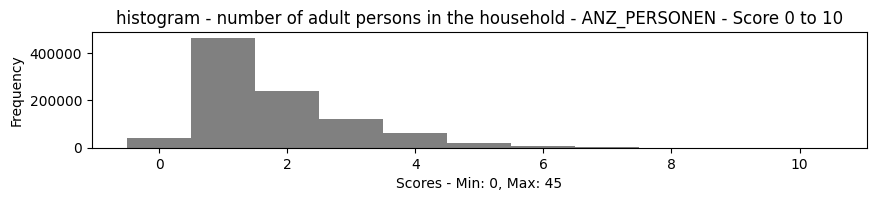

10 outliers (Score: %) 
 45: 0.0%, 40: 0.0%, 38: 0.0%, 37: 0.0%, 35: 0.0% … 8: 0.1%, 7: 0.2%, 6: 0.7%, 5: 2.3%, 4: 6.6%




In [88]:
'''
ANZ_PERSONEN  
- Value 0 might be strange or extreme but is possible
- outliers: household with over 10 adult persons is highly extreme or data error,
  that Value over 10 should be replaced to NaN
'''

view_feature (concat_intsec, 'ANZ_PERSONEN', False)

In [89]:
'''
NOTE
'''

p_process['3.1.1-ANZ_PERSONEN'] = 'replace Score > 10 to NaN'

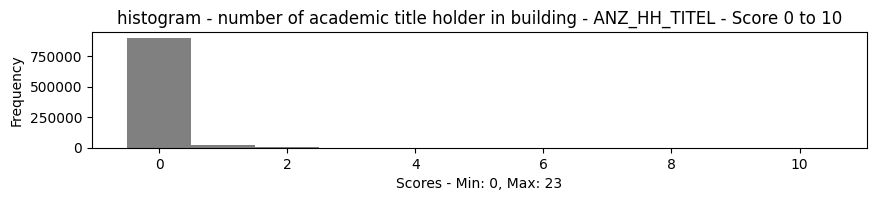

10 outliers (Score: %) 
 23: 0.0%, 20: 0.0%, 18: 0.0%, 17: 0.0%, 16: 0.0% … 5: 0.0%, 4: 0.0%, 3: 0.1%, 2: 0.3%, 1: 2.7%




In [90]:
'''
ANZ_HH_TITEL  
- No pre-processing needed: max values might be strange or extreme but are possible
'''

view_feature (concat_intsec, 'ANZ_HH_TITEL', False)

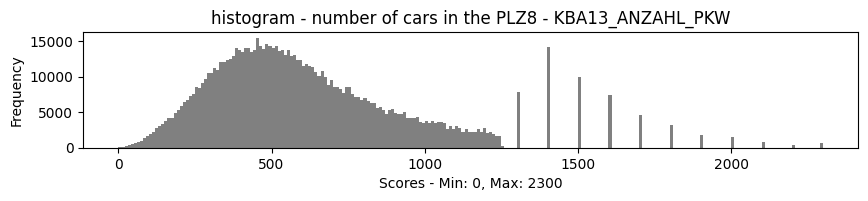

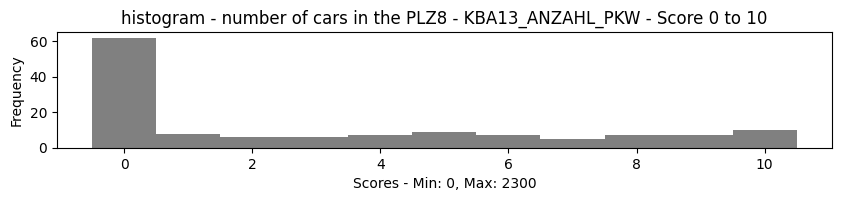

10 outliers (Score: %) 
 2300: 0.1%, 2200: 0.0%, 2100: 0.1%, 2000: 0.2%, 1900: 0.2% … 1800: 0.3%, 1700: 0.5%, 1600: 0.8%, 1500: 1.1%, 1400: 1.5%




In [91]:
'''
KBA13_ANZAHL_PKW
- in this feature values over 1250 is grouped by 100. 
  Log scaling is needed due to high skewness.
'''

view_feature (concat_intsec, 'KBA13_ANZAHL_PKW')

In [92]:
p_process['3.1.1-KBA13_ANZAHL_PKW'] = '[Log scaling]'

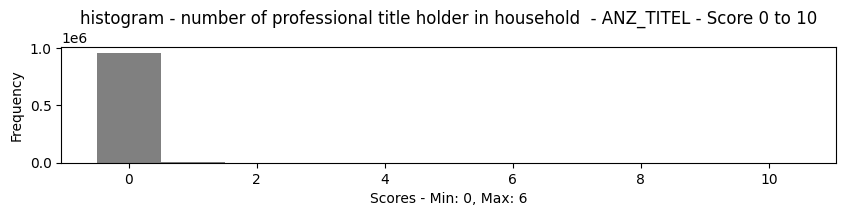

10 outliers (Score: %) 
 6: 0.0%, 5: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0% … 5: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0%, 1: 0.6%




In [93]:
'''
ANZ_TITEL
- it seems that there is no pre-processing needed.
  However, this feature is linked to ANZ_PERSONEN above
  that Score should be replaced to null if corresponding ANZ_PERSONEN is null.
'''

view_feature (concat_intsec, 'ANZ_TITEL', False)

In [94]:
p_process['3.1.1-ANZ_TITEL'] = 'replace Score to null if ANZ_PERSONEN is null'

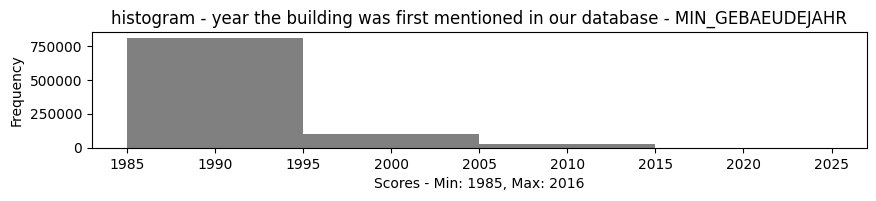

10 outliers (Score: %) 
 2016: 0.0%, 2015: 0.1%, 2014: 0.1%, 2013: 0.2%, 2012: 0.2% … 1989: 0.3%, 1988: 0.1%, 1987: 0.1%, 1986: 0.0%, 1985: 0.0%




In [95]:
'''
MIN_GEBAEUDEJAHR   
- No pre-processing needed
'''

view_feature (concat_intsec, 'MIN_GEBAEUDEJAHR', True, False)

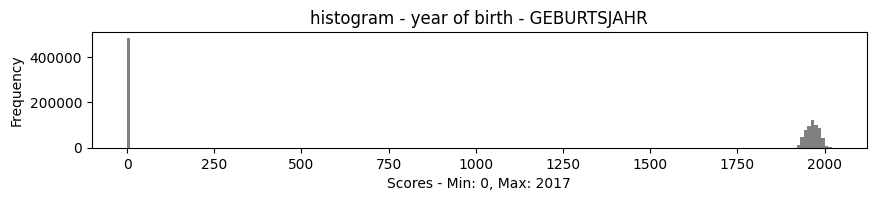

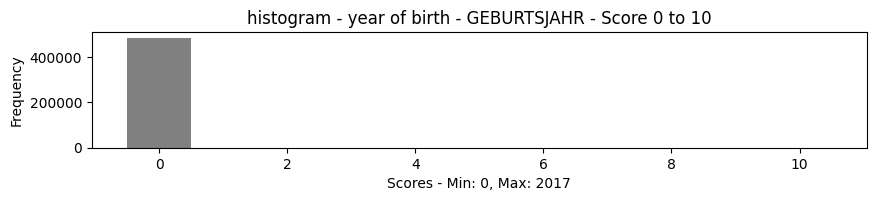

10 outliers (Score: %) 
  … 




In [96]:
'''
GEBURTSJAHR  
- outliers: birth year can not be 0, that Value < 1900 should be replaced to null
'''

view_feature (concat_intsec, 'GEBURTSJAHR')

In [97]:
p_process['3.1.1-GEBURTSJAHR'] = 'replace Score < 1900 to NaN'

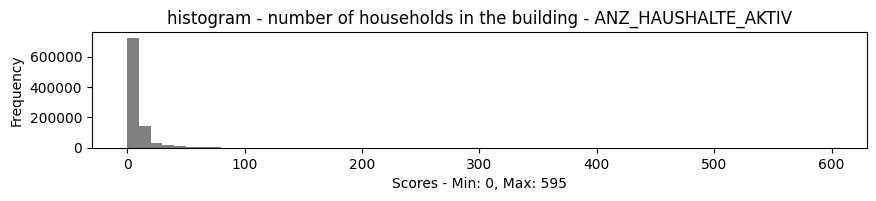

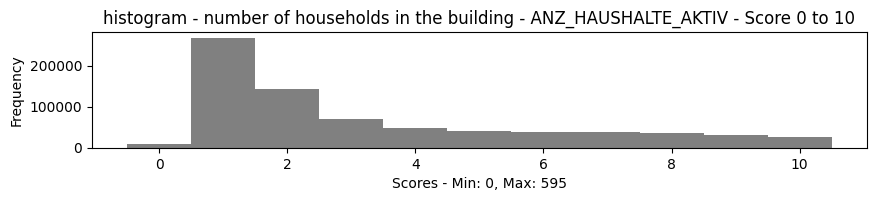

10 outliers (Score: %) 
 595: 0.0%, 536: 0.0%, 523: 0.0%, 515: 0.0%, 445: 0.0% … 26: 0.3%, 25: 0.3%, 24: 0.3%, 23: 0.4%, 22: 0.4%




In [98]:
'''
ANZ_HAUSHALTE_AKTIV  
- No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
- Log scaling is needed due to high skewness
'''

view_feature (concat_intsec, 'ANZ_HAUSHALTE_AKTIV')

In [99]:
'''
NOTE
'''

p_process['3.1.1-ANZ_HAUSHALTE_AKTIV'] = '[Log scaling]'

##### 3.1.2 string dataset Scores of intersection features

* 뭐뭐뭐

In [100]:
intsec_obj_score = dataset_summary(concat_intsec, ['object'], False)
intsec_obj_score

,Attribute,count,unique,top,freq,Desc,null_portion
0,OST_WEST_KZ,939798,2,W,759910,flag indicating the former GDR/FRG,0.132125
1,CAMEO_DEU_2015,933466,45,6B,66306,CAMEO classification 2015 - detailled classifi...,0.137973
2,CAMEO_DEUG_2015,933466,19,8,87739,CAMEO classification 2015 - Uppergroup,0.137973


In [101]:
'''
check if Scores in actual datasets are within range given by attr.
'''

# merge min/max values by Attribute in attr_num_score in 2.3.1
for i in intsec_obj_score.Attribute.unique():
    score_in_dataset = set(concat_intsec[i].unique())
    score_in_attr = set(attr.query('Attribute == "{}"'.format(i)).Score.values)
    
    print (i)
    print (f'a) scores in datasets: {score_in_dataset}')
    print (f'b) scores in datasets: {score_in_attr}')
    print (f'a) b) intersection: {score_in_dataset.intersection(score_in_attr)}')
    print (f'a) - b): {score_in_dataset - score_in_attr}')
    print (f'b) - a): {score_in_attr - score_in_dataset}', '\n')

OST_WEST_KZ
a) scores in datasets: {'W', 'O', nan}
b) scores in datasets: {'W', 'O', -1}
a) b) intersection: {'W', 'O'}
a) - b): {nan}
b) - a): {-1} 

CAMEO_DEU_2015
a) scores in datasets: {'7D', 'XX', '3B', '7E', '9E', '3A', '9C', '6E', '3D', '7A', '1E', '5A', '5B', '8A', '5E', '5C', '4C', nan, '2B', '3C', '5F', '5D', '1C', '6D', '7B', '8B', '4A', '4E', '9B', '8D', '6A', '6F', '6B', '1B', '8C', '2A', '1D', '4D', '7C', '2D', '4B', '6C', '9A', '1A', '2C', '9D'}
b) scores in datasets: {'7D', '3B', '7E', '9E', '3A', '9C', '6E', '3D', '1E', '5A', '5E', '5B', '7A', '8A', '5C', '4C', '2B', '9D', '3C', '5F', '1C', '5D', '6D', '7B', '8B', '4A', '4E', '9B', '8D', '6A', '6F', '6B', '1B', '8C', '2A', '1D', '7C', '2D', '4B', '6C', '9A', '1A', '2C', '4D'}
a) b) intersection: {'7D', '3B', '7E', '9E', '3A', '9C', '6E', '3D', '7A', '5A', '5E', '5B', '8A', '1E', '5C', '4C', '2B', '3C', '5F', '1C', '5D', '6D', '7B', '8B', '4A', '4E', '9B', '8D', '6A', '6F', '6B', '1B', '8C', '2A', '1D', '4D', '7C', '2D'

In [103]:
'''
NOTE
'''

p_process['3.1.2-CAMEO_DEU_2015'] = 'replace XX to null'
p_process['3.1.2-CAMEO_DEUG_2015'] = 'replace X to null and change dtypes of numbers in string form'

#### 3.2 exclusive features NOT in reference files

In [104]:
'''
concat_excl containing exclusive features of datasets
'''

concat_excl = concat_data[
    list(feature_dict['in_customers_notin_attr'])].copy()

##### 3.2.1 numeric dataset Scores of exclusive features

뭐뭐뭐

In [105]:
'''
excl_num_score containing Scores denoted in number
'''

excl_num_score = dataset_summary(concat_excl, ['int', 'float'])

number of Attribute(s): 92


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
0,D19_VERSI_ONLINE_QUOTE_12,778063.0,0.023798,0.483784,0.0,0.0,0.0,0.0,10.0,D19 versi online quote 12,0.281483,0 to 10
1,VHA,962778.0,0.503563,1.181750,0.0,0.0,0.0,0.0,5.0,Vha,0.110904,0 to 5
2,AKT_DAT_KL,962778.0,4.018992,3.569841,1.0,1.0,1.0,9.0,9.0,Act Dat KL,0.110904,1 to 9
3,KBA13_ANTG2,925792.0,2.774118,0.920952,0.0,2.0,3.0,3.0,4.0,KBA13 Ang2,0.145059,0 to 4
4,D19_SONSTIGE,1082873.0,2.525860,2.885597,0.0,0.0,0.0,6.0,7.0,D19 others,0.000000,0 to 7


min_max Scores: 
 ['0 to 10' '0 to 5' '1 to 9' '0 to 4' '0 to 7' '1 to 13' '1 to 11'
 '1 to 5' '0 to 449' '0 to 1' '1 to 1_082_873' '1 to 6' '0 to 3' '0 to 6'
 '1 to 56' '1 to 10' '2 to 18' '7 to 18' '0 to 25' '11 to 50' '0 to 11'
 '1_900 to 2_018' '0 to 2' '1 to 3' '4 to 18' '0 to 45']


* **data type of features with wider min/max Score gap**
  
min/max Score gap is not big. 아무 reference가 없으니 section_2에서 정리한 일반 원칙 적용하여 pre-processing

All features that have min/max Score gap over 10 and null portion below 50% are to be checked below.

In [106]:
'''
check features that have min/max Score gap over 10
'''
# from pv_min_max above, extract Attribute values having Score values over 7
gap_over10_attribute = excl_num_score[
    (excl_num_score['max'] - excl_num_score['min']) > 10].Attribute.unique()

gap_over10 = excl_num_score.query('Attribute.isin(@gap_over10_attribute)')
view_all(gap_over10)

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
6,VK_DISTANZ,959085.0,7.087279,3.367266,1.0,4.0,7.0,10.0,13.0,VK distance,0.114314,1 to 13
9,ANZ_STATISTISCHE_HAUSHALTE,939798.0,7.162317,14.347487,0.0,1.0,3.0,8.0,449.0,Anz statistical households,0.132125,0 to 449
14,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,0.000000,1 to 1_082_873
28,EXTSEL992,343437.0,34.911830,14.472052,1.0,25.0,35.0,48.0,56.0,Extsel992,0.682846,1 to 56
34,ALTER_KIND2,34599.0,13.442412,3.244667,2.0,11.0,14.0,16.0,18.0,Old child2,0.968049,2 to 18
36,ALTER_KIND4,1441.0,15.136711,2.431287,7.0,14.0,16.0,17.0,18.0,Old child4,0.998669,7 to 18
38,ALTERSKATEGORIE_FEIN,768084.0,13.087451,5.090172,0.0,10.0,14.0,17.0,25.0,Age category fine,0.290698,0 to 25
59,GEMEINDETYP,935123.0,24.275811,11.997949,11.0,12.0,22.0,30.0,50.0,Parish type,0.136443,11 to 50
62,ANZ_KINDER,962778.0,0.151364,0.501062,0.0,0.0,0.0,0.0,11.0,Anz children,0.110904,0 to 11
63,EINGEZOGENAM_HH_JAHR,962778.0,2003.044442,7.120764,1900.0,1997.0,2002.0,2009.0,2018.0,Intended HH year,0.110904,1_900 to 2_018


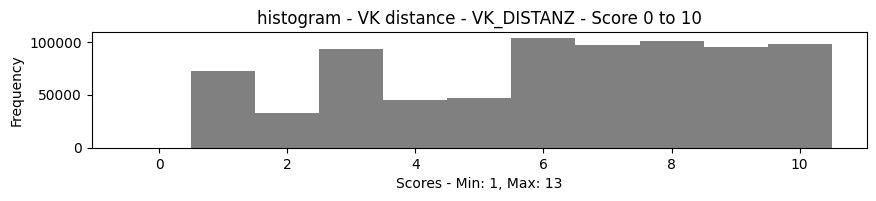

10 outliers (Score: %) 
  … 




In [108]:
'''
VK_DISTANZ  
- No pre-processing needed
'''

view_feature (concat_excl, 'VK_DISTANZ', False, True)

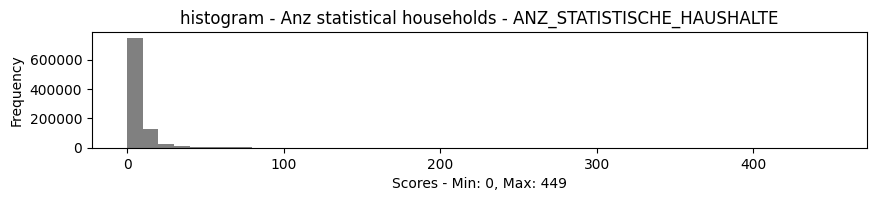

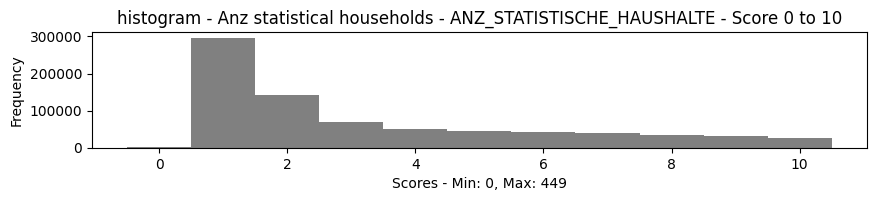

10 outliers (Score: %) 
 449: 0.0%, 445: 0.0%, 375: 0.0%, 371: 0.0%, 369: 0.0% … 23: 0.3%, 22: 0.4%, 21: 0.4%, 20: 0.4%, 19: 0.5%




In [109]:
'''
ANZ_STATISTISCHE_HAUSHALTE   
  - No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
  - Log scaling is needed due to high skewness
'''

view_feature (concat_excl, 'ANZ_STATISTISCHE_HAUSHALTE')

In [110]:
'''
NOTE
'''

p_process['3.2.1-ANZ_HAUSHALTE_AKTIV'] = '[Log scaling]'

In [ ]:
'''
NOTE
LNR is the serial index of dataset
'''

p_process['3.2'] = 'drop LNR'

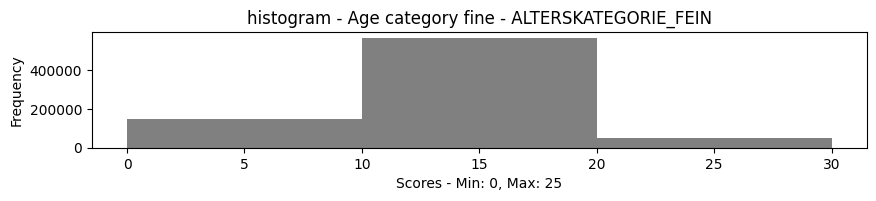

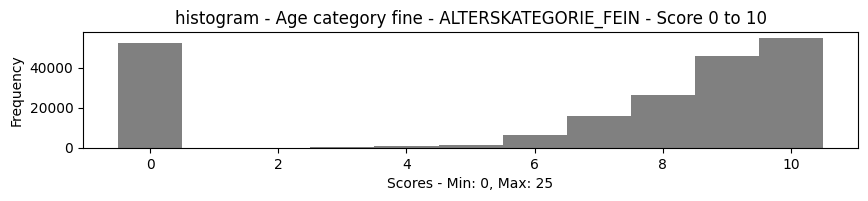

10 outliers (Score: %) 
  … 




In [111]:
'''
ALTERSKATEGORIE_FEIN  
- 0을 null로
'''

view_feature (concat_excl, 'ALTERSKATEGORIE_FEIN')

In [112]:
p_process['3.2.1-ALTERSKATEGORIE_FEIN'] = 'replace 0 to null'

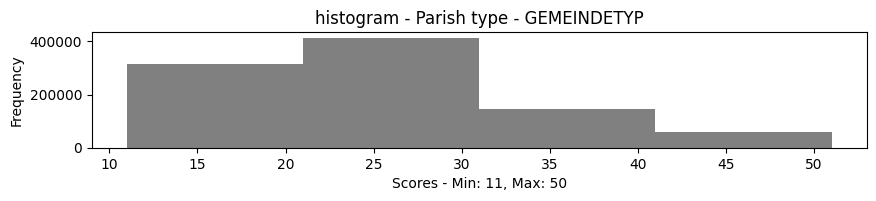

10 outliers (Score: %) 
  … 




In [113]:
'''
GEMEINDETYP   
- No pre-processing needed, 정확한 의미는 모르겠으나 극단적 특이성은 없음
'''

view_feature (concat_excl, 'GEMEINDETYP', True, False)

* ANZ_KINDER  
  - 0을 null로 보면 대부분 값이 없으므로 Drop

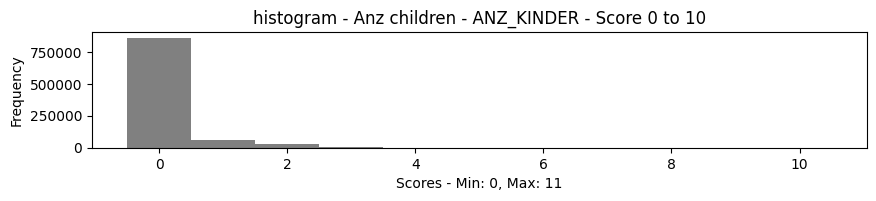

10 outliers (Score: %) 
 11: 0.0%, 9: 0.0%, 8: 0.0%, 7: 0.0%, 6: 0.0% … 5: 0.0%, 4: 0.1%, 3: 0.7%, 2: 3.0%, 1: 6.5%




In [116]:
'''
ANZ_KINDER  
  - 0을 null로 보면 대부분 값이 없으므로 Drop
'''

view_feature (concat_excl, 'ANZ_KINDER', False, True)

In [117]:
p_process['3.2.1-ANZ_KINDER'] = 'drop feature'

* EINGEZOGENAM_HH_JAHR 
  - outliers: Eng translation is not completely understandable, but 3 outliers can be replaced to NaN 

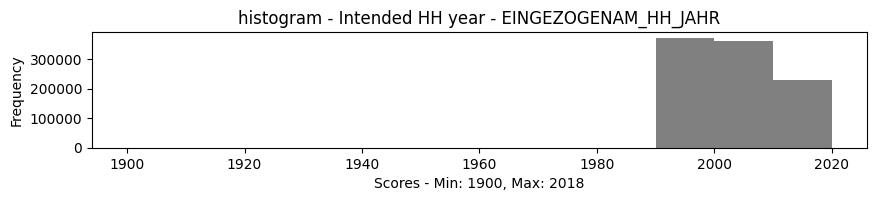

10 outliers (Score: %) 
 1971: 0.0%, 1904: 0.0%, 1900: 0.0% … 1971: 0.0%, 1904: 0.0%, 1900: 0.0%




In [118]:
'''
EINGEZOGENAM_HH_JAHR 
- outliers: Eng translation is not completely understandable, but 3 outliers can be replaced to null
'''

view_feature (concat_excl, 'EINGEZOGENAM_HH_JAHR', True, False)

In [119]:
p_process['3.2.1-EINGEZOGENAM_HH_JAHR'] = 'replace Value < 1980 to null'

* VERDICHTUNGSRAUM   
  - No pre-processing needed with Eng translation not completely understandable

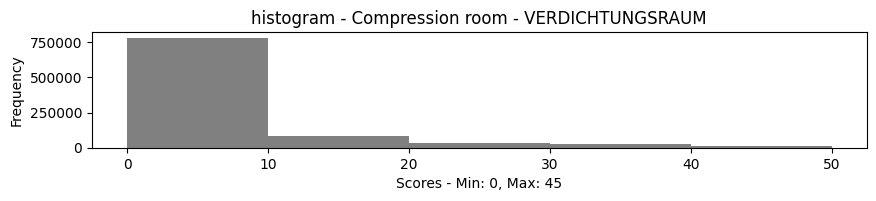

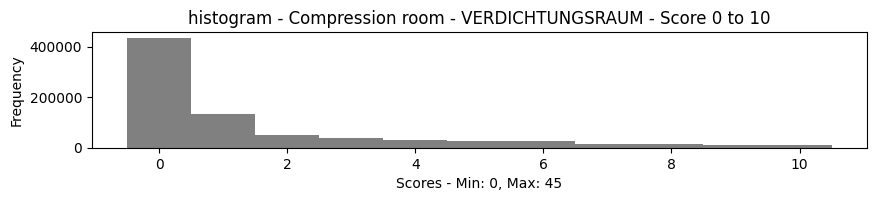

10 outliers (Score: %) 
 45: 0.2%, 44: 0.2%, 43: 0.2%, 42: 0.2%, 41: 0.1% … 17: 0.8%, 16: 0.8%, 15: 0.8%, 14: 0.9%, 13: 1.0%




In [120]:
'''
VERDICHTUNGSRAUM   
- No pre-processing needed although Eng translation not completely understandable
'''

view_feature (concat_excl, 'VERDICHTUNGSRAUM')

##### 3.2.2 string dataset Scores of exclusive features

///// For ....

In [121]:
'''
excl_obj_score containing Scores denoted in obj
'''

excl_obj_score = dataset_summary(concat_excl, ['object'])

number of Attribute(s): 5


,Attribute,count,unique,top,freq,Desc,null_portion
0,CUSTOMER_GROUP,191652,2,MULTI_BUYER,132238,Customer Group,0.823015
1,D19_LETZTER_KAUF_BRANCHE,778063,35,D19_UNBEKANNT,227248,D19 Last purchase industry,0.281483
2,CAMEO_INTL_2015,933466,43,51,83563,CAMEO INTL 2015,0.137973
3,PRODUCT_GROUP,191652,3,COSMETIC_AND_FOOD,100860,Product Group,0.823015
4,EINGEFUEGT_AM,939798,5254,1992-02-10 00:00:00,448482,Finded on,0.132125


In [124]:
'''
check if abnormal Scores exist in actual datasets.
'''
# exclude high null_portion rows
excl_obj_score = excl_obj_score.query('null_portion < 0.5')

# excl_obj_val = dict()
for i in excl_obj_score.Attribute.unique():
    
    print (i)
    print (f'scores in datasets: {set(concat_excl[i].unique())}', '\n')

D19_LETZTER_KAUF_BRANCHE
scores in datasets: {'D19_BANKEN_GROSS', 'D19_TECHNIK', 'D19_UNBEKANNT', 'D19_SONSTIGE', 'D19_VERSICHERUNGEN', 'D19_BUCH_CD', 'D19_SAMMELARTIKEL', 'D19_BEKLEIDUNG_REST', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_TIERARTIKEL', 'D19_TELKO_MOBILE', 'D19_BANKEN_REST', 'D19_REISEN', 'D19_DIGIT_SERV', 'D19_VOLLSORTIMENT', 'D19_BIO_OEKO', 'D19_GARTEN', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_DROGERIEARTIKEL', 'D19_HAUS_DEKO', 'D19_ENERGIE', 'D19_BEKLEIDUNG_GEH', 'D19_SCHUHE', 'D19_BANKEN_LOKAL', 'D19_BILDUNG', 'D19_FREIZEIT', 'D19_TELKO_REST', nan, 'D19_HANDWERK', 'D19_RATGEBER', 'D19_VERSAND_REST', 'D19_WEIN_FEINKOST', 'D19_BANKEN_DIREKT', 'D19_KINDERARTIKEL'} 

CAMEO_INTL_2015
scores in datasets: {'XX', '43', '12', '13', 12.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 25.0, '32', 31.0, 32.0, 33.0, 34.0, 35.0, '35', '34', '33', 41.0, 43.0, 44.0, 45.0, '41', 51.0, 52.0, 54.0, 55.0, '25', '55', '51', '14', '44', '24', nan, '54', '45', '52', '15', '31', '23', '22'} 

EINGE

In [125]:
'''
NOTE
'''

p_process['3.2.2-CAMEO_INTL_2015'] = 'replace X to null and change dtypes of numbers in string form'
p_process['3.1.2-EINGEFUEGT_AM'] = 'change dtype to datetime only with year values as there are too many unique values'

### 4. Pre-processing

In [126]:
p_process = {'pre_processing_itmes' : p_process}
p_process_items = pd.DataFrame(p_process).reset_index()
p_process_items

,index,pre_processing_itmes
0,2.3,drop features LP_FAMILIE_GROB / LP_STATUS_GROB
1,2.3.1-to_null,"replace Scores, of which corresponding Meaning..."
2,2.3.1-value_-1,replace all -1 Score to null
3,3.1.1,"replace Score 0 of LP_LEBENSPHASE_FEIN, LP_LEB..."
4,3.1.1-ANZ_HAUSHALTE_AKTIV,[Log scaling]
5,3.1.1-ANZ_TITEL,replace Score to null if ANZ_PERSONEN is null
6,3.1.1-GEBURTSJAHR,replace Score < 1900 to NaN
7,3.1.1-KBA13_ANZAHL_PKW,[Log scaling]
8,3.1.1_ANZ_PERSONEN,replace Score > 10 to NaN
9,3.1.2-CAMEO_DEUG_2015,replace X to null and change dtypes of numbers...


[function] miss_val_summary

In [127]:
def miss_val_summary(df, axis_val, x_bin = 2, bar_chart = True):
    '''
    function to display summary, bar-chart (optional) and histogram
    of missing value by column or raw
    df: dataframe
    axis_val: str, one of 'column' or 'row'
    x_bin: size of x bin, 10 as default
    bar_chart: option of bar chart display 
    '''
    # index of axis
    axis_idx = 0 if axis_val == 'column' else 1
    
    # % of missing values
    missing_pct = df.isnull().mean(axis = axis_idx) * 100
    df_desc = missing_pct.describe()

    # summary of missing value
    print (
        '% of missing value in ' + str(int(df_desc[0])) + ' ' + axis_val + 's of ' + df.name)
    print (df_desc[1:].to_string())
    
    # bar-chart of missing value
    if bar_chart:
        missing_pct.plot(
            kind = 'bar', figsize=(10, 3), color='gray',
            
            title = ('bar chart - ' + df.name + ': missing value by ' + axis_val),
            ylabel = '% of missing value',
            xlabel = (str(int(df_desc[0])) + ' columns'),
            xticks = [],
            );
        plt.show()
    
    # hist of missing value
    x_range = ((df_desc[-1] + 10) // 10) * 10 + x_bin
    ax = missing_pct.plot(
        kind = 'hist', figsize=(10, 3), color='gray',
        
        bins = np.arange(0, x_range, x_bin),
        title = ('histogram - ' + df.name + ': missing value by ' + axis_val)
        )
    ax.set_xlabel('% of missing value');
    plt.show()

% of missing value in 366 columns of asdias
mean    10.268016
std     12.164049
min      0.000000
25%      0.000000
50%     11.871354
75%     12.023000
max     99.864792


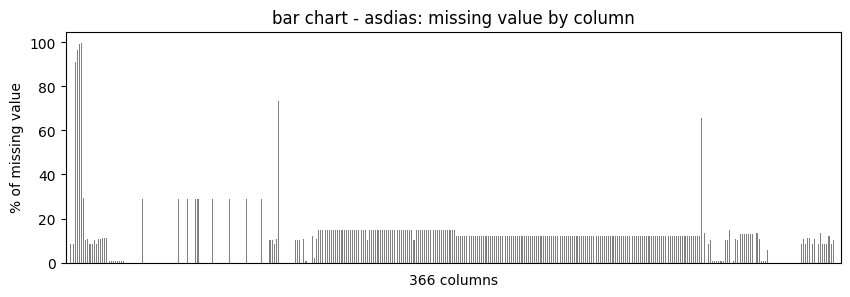

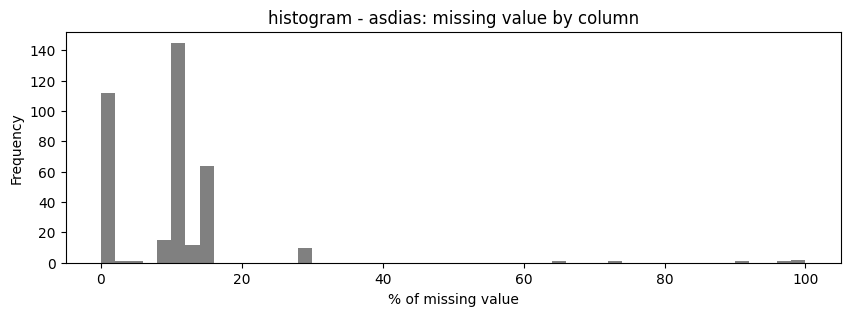

In [129]:
'''
missing value by columns of azdias
'''
azdias.name = 'asdias'
miss_val_summary(azdias, 'column')

% of missing value in 369 columns of cistomers
mean    19.604925
std     15.143659
min      0.000000
25%      0.000000
50%     26.757352
75%     26.757352
max     99.876860


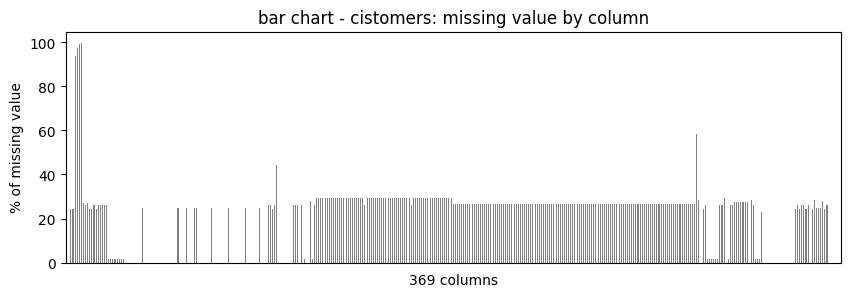

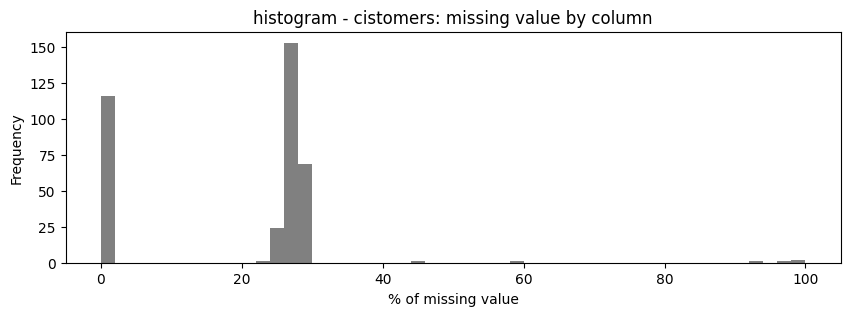

In [130]:
'''
missing value by column
'''
customers.name = 'cistomers'
miss_val_summary(customers, 'column')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

Work / Ref

In [ ]:
# def col_val (df):
#     '''
#     function to check values of dataframe columns
#     df : dataframe
#     '''
#     # for i in df.columns:
#     #     print (i, '-', df[i].nunique(), 'values', '\n',
#     #         df[i].value_counts(), '\n', '*     *     *')
#     for i in df.columns:
#         print (i, '-', df[i].nunique(), 'values', '\n',
#         list(df[i].unique()), '\n', '*     *     *')

In [ ]:
# # from googletrans import Translator

# # Create an instance of the Translator
# translator = Translator(service_urls=['translate.google.com'])

# # Text to be translated
# text = "AGER_TYP"

# # Translate the text from German to English
# translation = translator.translate(text, src='de', dest='en')

# # Print the translated text
# print("Original text (German):", text)
# print("Translated text (English):", translation.text)

In [ ]:
# def miss_val_hist(df, axis_val, x_bin = 10):
#     '''
#     function to display missing value histogram by column or raw
#     df: dataframe
#     axis_val: str, one of 'column' or 'row'
#     x_bin: size of xtick bin, 10 as default 
#     '''
#     # axis value
#     axis_num = 0 if axis_val == 'column' else 1
    
#     # % of missing values
#     missing_pct = df.isnull().mean(axis = axis_num) * 100

#     # max % of missing values by column
#     missing_pct_max = missing_pct.max()
#     print ('max % of missing values by ' + axis_val + ': ', missing_pct_max)

#     # plot missing values by column
    
#     print (missing_pct.describe())
    
#     x_range = ((missing_pct_max + x_bin * 2) // x_bin) * x_bin

#     ax = missing_pct.plot(
#         kind = 'hist', figsize=(10, 3), color='gray',
#         bins = np.arange(0, x_range, 10),
#         title = (df.name + ': missing value by ' + axis_val)
#         )
#     ax.set_xlabel('% of missing value');

In [ ]:
# 파이써닉 하지 못한 코드
# # missing value overview
# for i in range(0, ((azdias.shape[1] + 100) // 100) * 100, 100):
#     msno.matrix(azdias.iloc[:, i : i + 99],
#                 figsize=(10, 3), fontsize = 12, labels = False, sparkline = False)
#     plt.title('missing value overview: col ' + str (i) + ' to ' + str (min(i + 99, azdias.shape[1] - 1)),
#               fontsize = 12);

In [ ]:
# # % of columns with missing values of over 30%
# (azdias.isnull().mean() * 100 > 30).mean()

In [ ]:
# # % of columns with missing values of 25% to 30%
# ((azdias.isnull().mean() * 100 > 25) & (30 >= azdias.isnull().mean() * 100)).mean()

In [ ]:
# 아마도 쓰지 않을 plot
# plot = azdias_col_missing_pct.plot(
#     kind = 'bar', figsize=(10, 3), color='dimgray', xticks = [],
#     title = 'azdias_col_missing_pct',
#     xlabel = '366 columns',
#     ylabel = '% of missing values')

In [ ]:
# num_df = customers.select_dtypes(include=['float', 'int64']).iloc[:, 1:]
# num_df.head()

In [ ]:
# len(pd.unique(customers.select_dtypes(include='float').values.flatten()).tolist())

In [ ]:
# with pd.option_context(
#     'display.max_rows', None, 'display.max_colwidth', None):
#     display(pd.DataFrame(attr.apply(lambda x: x.unique())))

In [ ]:
# attr_not_null = ~(attr.Attribute.isna())
# attr.loc[attr_not_null, 'Description'] = attr.loc[
#     attr_not_null, 'Description'] + ' ' + attr.loc[attr_not_null, 'desc_shift']

# desc_to_null = (attr.Attribute.isna()) & ~(attr.Description.isna())
# attr.loc[desc_to_null, 'Description'] = np.nan
# attr = attr.drop(columns = 'desc_shift')
# attr.loc[attr_with_value.shift(-1, fill_value = True), 'Description']
# attr_shift = attr_null.shift
# attr[attr_null.shift, 'Description'] = attr.loc[
#     attr_null.shift(fill_value = False), 'Description'] + ' ' + attr[attr_null, 'Description']

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# info_mg = info_mg.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
# # attr_excl = attr[attr.Attribute.isin(attr_excl)].copy()
# attr_not_null = attr.dropna(subset = 'Attribute').copy()
# attr_not_null = attr_not_null.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

# info_mg = pd.concat(
#     [info_mg, attr_not_null[['Attribute', 'Description']]],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# attr_excl = attr[attr.Attribute.isin(attr_excl)][['Attribute', 'Description']].copy()

# info_mg = pd.concat(
#     [info_mg, attr_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# # info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# view_all(info_mg)

In [ ]:
# '''
# to 2258 rows of Attribute in attr, add 13 values exclusively in info,
# and remove 52 values exclusively in information files
# '''

# attr_mg = attr.copy()
# info_excl = info[info.Attribute.isin(info_excl)][['Attribute', 'Description']].copy()
# info_excl['Value'] = 'form info'
# info_excl['Meaning'] = 'form info'

# attr_mg = pd.concat(
#     [attr_mg, info_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# # info_mg = info_mg.drop_duplicates()

# # info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(attr_mg.info())
# attr_mg.head()

In [ ]:
# attr_mg.tail(30)

In [ ]:
# '''
# there are 93 and 51 exclusive values in data and information files
# '''

# datafile_Attr = azdias_Attr.union(customers_Attr)
# infofile_Attr = info_Attr.union(attr_Attr)

# datafile_excl = datafile_Attr - infofile_Attr
# infofile_excl = infofile_Attr - datafile_Attr

# print (len(datafile_excl), 'Attribute value(s) exclusively in data files:',
#        '\n', datafile_excl)
# print (len(infofile_excl), 'Attribute value(s) exclusively in information files:',
#        '\n', infofile_excl)

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# info['Information level'] = info['Information level'].fillna(method = 'ffill')

# info.head()

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# attr[['Attribute', 'Description']] = attr[
#     ['Attribute', 'Description']].fillna(method = 'ffill')

# attr.head(10)

In [ ]:
# '''
# To enhance readability of data set - over 100 features are without description -   
# I added 14 Description values from attr, and made a column of translation   
# (ger_to_eng) to df_feature using code below.
# However as this code-running takes somewhat long time, I saved the dataframe processed
# as df_feature.xlsx in root folder
# '''

# # For values of Attribute without Description, add 14 Description values from attr
# df_feature.set_index('Attribute', inplace = True)

# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# df_feature.update(attr_excl)

# df_feature.reset_index(inplace = True)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# df_feature['ger_to_eng'] = np.where(
#     df_feature.Description.isnull(),
#     df_feature.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# df_feature['Desc'] = df_feature.Description.fillna('') + df_feature.ger_to_eng.fillna('')

# # # sort by Attribute and Information level
# # df_feature.sort_values(by = ['Attribute', 'Information level'], inplace= True)

# # df_feature = pd.read_excel('df_feature.xlsx', index_col = [0])
# # df_feature.head(10)

In [ ]:
# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# df_feature.Description = df_feature.Description.mask(
#     df_feature.Attribute == attr_excl.Attribute,
#     attr_excl.Description
#     )
# print ('Attributes missing Description:', df_feature[df_feature.Description.isna()].shape[0])
# print (df_feature.shape)
# df_feature.head()

# ValueError: Can only compare identically-labeled Series objects

In [ ]:
# feature_desc.set_index('Attribute', inplace = True)

# attr_Attr = set(attr.Attribute.dropna().unique())
# info_Attr = set(info.Attribute.dropna().unique())
# attr_excl = attr[
#     attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# feature_desc.update(attr_excl)

# feature_desc.reset_index(inplace = True)

In [ ]:
# '''
# alignment of features between data files: 
# df customers has 3 more exclusive columns
# '''

# azdias_Attr = set(azdias.columns)
# customers_Attr = set(customers.columns)

# print(azdias_Attr - customers_Attr)
# print(customers_Attr - azdias_Attr)

In [ ]:
# '''
# alignment of features between information files
# '''
# info_Attr = set(info.Attribute.dropna().unique())
# attr_Attr = set(attr.Attribute.dropna().unique())

# # info_excl = info_Attr - attr_Attr
# # attr_excl = attr_Attr - info_Attr

# print (len(info_Attr - attr_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - attr_Attr)
# print (len(attr_Attr - info_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - info_Attr)
# '''
# alignment of features between customers and information files
# '''
# print ('Attribute between customers and info')
# print (len(customers_Attr - info_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - info_Attr)
# print (len(info_Attr - customers_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - customers_Attr)
# print ('In', len(info_Attr), 'features of info,', 
#        len(info_Attr) - len(info_Attr - customers_Attr), 'features are in Attribute of customers', '\n')

# print ('Attribute between customers and attr')
# print (len(customers_Attr - attr_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - attr_Attr)
# print (len(attr_Attr - customers_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - customers_Attr)
# print ('In', len(attr_Attr), 'features of attr,',
#        len(attr_Attr) - len(attr_Attr - customers_Attr), 'features are in Attribute of customers')

In [ ]:
# list(feature_dict.keys())[0]
# feature_dict.values()

In [ ]:
# values = np.array([1, 2, 3, 4])

# subtractions = np.subtract.outer(values, values)[np.triu_indices(len(values), k=1)]

# for result in subtractions:
#     print(result)

In [ ]:
# for i, (k, v) in enumerate(feature_dict.items()):
#     for j in range(i + 1, 4):
#             result = values[i] - values[j]
#             print(f"{values[i]} - {values[j]} = {result}")
#     print (i, k, v)
    
# for i, (k, v) in enumerate(zip(list(feature_dict.keys()), list(feature_dict.values()))):
#     print (i, (k, v))

In [ ]:
# '''
# customers에는 없고 attr에만 있는 42개 Attribute는 Desc가 없으으로
# (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# print ('customers에는 없고 attr에만 있는 42개 Attribute 수:', 
#        attr_num[attr_num.Desc.isna() == True].Attribute.nunique(),
#        '\n')

# attr_num = attr_num[attr_num.Desc.isna() == False]
# print (attr_num.info())

In [ ]:
# '''
# str data of column Value
# '''
# # attr_num with only numeric values in Value
# attr_str = attr[attr['Value_dtype'] == str].copy()
# print (attr_str.shape) 

# # add Desc and Information level
# attr_str = vlookup(attr_str, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
# print (attr_str.info())
# attr_str.head()

In [ ]:
# '''
# 3개 null attribute는 정수와 문자를 모두 값을로 갖는 것들로 42개는 유효하고
# 이 42개는 다음 section에서 볼 예정이므로 (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# # attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

# attr_str = attr_str[attr_str.Desc.isna() == False]
# print (attr_str.info())

In [ ]:
# # attr_str_to_check = pv_attr_str[pv_attr_str.Meaning.str.contains('numeric value')].Attribute
# attr_str_to_check = pv_attr_str[
#     pv_attr_str.index.get_level_values(2).str.contains('numeric value')].index.get_level_values(0)
# # 먼저 추후 체크할 것들을 뽑아 놓고
# attr_str_to_check

In [ ]:
# pv_attr_str = pd.DataFrame(pv_attr_str[
#     ~(pv_attr_str.index.get_level_values(0).isin(attr_str_to_check))
#     &~(pv_attr_str.index.get_level_values(2) == 'unknown')
#     ].to_records())

# pv_attr_str = pd.pivot_table(
#     pv_attr_str,
#     index = ['Attribute', 'Desc'],
#     values = 'Value',
#     aggfunc = lambda x: list(x)
#     )

# view_all(pv_attr_str)

In [ ]:
# print(not_in_attr_str.values.T.shape)
# not_in_attr_str.values.T.tolist()

In [ ]:
# for i in concat_cont_ft[1:]:

#     min_val = cc_num[i].min()
#     max_val = cc_num[i].max()
#     bin_interval = 1
#     bin_edges = np.arange(min_val, max_val + bin_interval, bin_interval)

#     desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
#     count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = bin_edges,
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' ' + i)
#         );
#     ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
#     plt.show()
    
#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = np.arange(-0.5, 11.5, 1),
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' - Value 0 to 10')
#         );
#     ax.set_xlabel('Values');
#     plt.show()
    
#     # Define the outlier thresholds by applying multiplier 5.0
#     q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
#     q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
#     iqr = q3 - q1
#     lower_threshold = q1 - 5.0 * iqr
#     upper_threshold = q3 + 5.0 * iqr

#     # Identify outliers
#     col_val = cc_num[i].values
#     outliers = sorted(set([i for i in col_val if i < lower_threshold or i > upper_threshold]), reverse = True)
#     for j in outliers:
#         print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
#     print ('\n', '==========' * 10)

In [ ]:
# for i in concat_cont_ft[1:]:

#     min_val = cc_num[i].min()
#     max_val = cc_num[i].max()
#     # bin_interval = 1
#     bin_edges = np.arange(min_val, max_val + 10, 10)

#     desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
#     count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = bin_edges,
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' ' + i)
#         );
#     ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
#     plt.show()
    
#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = np.arange(-0.5, 11.5, 1),
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' - Value 0 to 10')
#         );
#     ax.set_xlabel('Values');
#     plt.show()
    
#     # Define the outlier thresholds by applying multiplier 1.5
#     q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
#     q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
#     iqr = q3 - q1
#     lower_threshold = q1 - 1.5 * iqr
#     upper_threshold = q3 + 1.5 * iqr

#     # Identify outliers
#     col_val = cc_num[i].values
#     outliers = sorted(
#         set([i for i in col_val if i < lower_threshold or i > upper_threshold]),
#         reverse = True)
#     # for j in outliers:
#     #     print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
        
#     outlier_list = [str(int(j)) + ': ' + '{:.1%}'.format((cc_num[i] == j).sum() / count_val)
#                     for j in outliers]
    
#     print('Outliers (Value: %)')
#     for j in range(0, len(outlier_list), 10):
#         print (', '.join(outlier_list[j: j+10]))
#     print ('\n')

**[function]** score_meaning_val

In [ ]:
# def score_meaning_val(data, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes']):
#     '''
#     function to check unique values of Score and Meaning by Attribute
#     data : dataframe to examine
#     pv_idx: list of pivot_table index
#     '''
#     data = vlookup(data, feature_desc, 'Attribute', ['Desc', 'Additional notes'], nan_val = 'no_info')
#     pv = pd.pivot_table(
#         data,
#         index = pv_idx,
#         values = ['Meaning', 'Score'],
#         aggfunc = lambda x: list(x))
    
#     return pv

In [ ]:
# def verify_null(data, null_list, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes']):
#     '''
#     function to display the summary of Score and Meaning values,
#     when Meaning values are in the list containing possibly null values.   
    
#     data: dataframe to examine
#     null_list: list of possibly null values
#     pv_idx: pivot_table index
#     '''
#     null_check_Attribute = data[data['Meaning'].isin(null_list)]['Attribute'].to_list()
#     null_check = data[data['Attribute'].isin(null_check_Attribute)]
    
#     null_check = vlookup(null_check, feature_desc, 'Attribute', ['Desc', 'Additional notes'], fill_na = 'no_info')
#     pv = pd.pivot_table(
#         null_check,
#         index = pv_idx,
#         values = ['Score', 'Meaning'],
#         aggfunc = lambda x: list(x))
    
#     return pv

In [ ]:
# # For values of Attribute without Description, add 12 Description values from attr
# attr_to_add = attr[['Attribute', 'Description']].copy()
# attr_to_add.dropna(inplace = True)
# attr_to_add = attr_to_add.rename(columns = {'Description': 'Description_to_add'})

# feature_desc = vlookup(feature_desc, attr_to_add, 'Attribute')
# feature_desc.Description = np.where(
#     ((feature_desc.Description.isnull() == True) & (feature_desc.Description_to_add.isnull() == False)),
#     feature_desc.Description_to_add,
#     feature_desc.Description)
# feature_desc = feature_desc.drop('Description_to_add', axis=1)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# feature_desc['ger_to_eng'] = np.where(
#     feature_desc.Description.isnull(),
#     feature_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# feature_desc['Desc'] = feature_desc.Description.fillna('') + feature_desc.ger_to_eng.fillna('')

# feature_desc.info()

In [ ]:
# # pv_min_max 2.3.1 변경 for merge
# min_max_copy = pd.DataFrame(pv_min_max.to_records())
# min_max_copy.columns = list(
#     min_max_copy.columns[:2]) + list(eval(i)[0] for i in min_max_copy.columns[2:])
# min_max_copy

In [ ]:
# import pandas as pd
# import numpy as np
# from IPython.display import display
# import sys
# from contextlib import ExitStack

# def view_all (data):
#     '''
#     function to display all contents of data
#     '''
#     # with ExitStack() as stack:
#     #     stack.enter_context(pd.option_context(
#     #     'display.max_rows', None,
#     #     'display.max_colwidth', None,
#     #     'display.max_seq_items', None
#     #     ))
#     #     stack.enter_context(np.printoptions(threshold=np.inf))
    
#     # np.set_printoptions(threshold = sys.maxsize)
    
#     with pd.option_context(
#     'display.max_rows', None, 
#     'display.max_colwidth', None,
#     'display.max_seq_items', None,
#     ):
#         display(data)

### eod